In [191]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [186]:
region = "STs_left"

labels_path = "/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/participants.csv"
base_path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation"
    

region_path = os.path.join(base_path, region)
    
# Trouver le nom du dossier unique automatiquement
subdirs = [d for d in os.listdir(region_path) if os.path.isdir(os.path.join(region_path, d))]
if len(subdirs) != 1:
    raise RuntimeError(f"Il y a {len(subdirs)} sous-dossiers dans {region_path}, impossible de choisir automatiquement car il y a plusieurs modèles enregistrés par région.")
model_folder = subdirs[0]

# Construire les chemins complets
embedding_path = os.path.join(region_path, model_folder, "dHCP_random_embeddings", "full_embeddings.csv")

In [187]:
# Chargement et alignement
labels_df = pd.read_csv(labels_path)
embeddings = pd.read_csv(embedding_path, index_col=0)
embeddings = embeddings.loc[embeddings.index.isin(labels_df['Subject'])]
labels = labels_df.set_index('Subject').loc[embeddings.index, 'birth_age']


print("labels", labels[0:15])

print("Shape embeddings:", embeddings.shape)
print("Shape labels:    ", labels.shape)



labels ID
sub-CC00065XX08    40.428571
sub-CC00067XX10    40.000000
sub-CC00068XX11    40.428571
sub-CC00071XX06    39.857143
sub-CC00073XX08    40.714286
sub-CC00074XX09    39.714286
sub-CC00075XX10    38.571429
sub-CC00080XX07    39.285714
sub-CC00082XX09    39.428571
sub-CC00086XX13    40.571429
sub-CC00087AN14    35.714286
sub-CC00088XX15    40.285714
sub-CC00091XX10    41.285714
sub-CC00096XX15    39.571429
sub-CC00098AN17    36.571429
Name: birth_age, dtype: float64
Shape embeddings: (374, 32)
Shape labels:     (374,)


In [152]:
# Optionnel : Filtrer les données dont l'âge est inférieur à 37.5 semaines

# labels = labels[labels <= 37.5]
# embeddings = embeddings.loc[labels.index]

# print("Shape embeddings after filtering:", embeddings.shape)
# print("Shape labels after filtering:    ", labels.shape)

Shape embeddings after filtering: (105, 32)
Shape labels after filtering:     (105,)


In [188]:
# Standardisation
scaler = StandardScaler()
X = scaler.fit_transform(embeddings.values)
y = labels.values

# Validation croisée adaptée
kf = KFold(n_splits=5, shuffle=True, random_state=5)

#Recherche d'hyper‑paramètre (sans normalize)
model = LinearRegression()
param_grid = {'fit_intercept': [True, False]}
grid_search = GridSearchCV(
    model, param_grid, cv=kf,
    scoring='neg_mean_squared_error', n_jobs=-1
)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Prédictions & métriques de régression
y_pred = cross_val_predict(best_model, X, y, cv=kf)

mae = mean_absolute_error(y, y_pred)
r2  = r2_score(y, y_pred)


print(f"R² : {r2:.4f}")
print(f"MAE : {mae:.2f} semaines")

# Performance par split
cv_mse = -cross_val_score(best_model, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_r2  =  cross_val_score(best_model, X, y, cv=kf, scoring='r2')
cv_mae = cross_val_score(best_model, X, y, cv=kf, scoring='neg_mean_absolute_error')
print("CV MAEs:", -cv_mae)
print("CV MSEs:", cv_mse)
print("Mean CV MSE :", cv_mse.mean())
print("CV R²s :", cv_r2)
print("Mean CV R² :", cv_r2.mean())


Best parameters: {'fit_intercept': True}
R² : 0.3056
MAE : 2.95 semaines
CV MAEs: [3.09369648 2.92431522 3.07949549 2.94208612 2.70796402]
CV MSEs: [14.52048632 13.25753395 15.28279145 14.02488054 11.17157596]
Mean CV MSE : 13.651453644359089
CV R²s : [0.2458685  0.22579772 0.06594161 0.40873104 0.48636899]
Mean CV R² : 0.2865415706848277


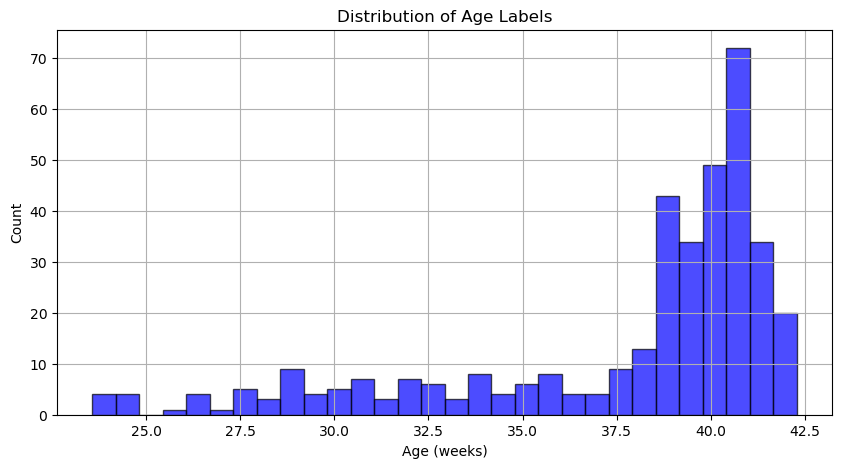

In [189]:
# Visualisation of labels distribution
plt.figure(figsize=(10, 5))
plt.hist(labels, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Age (weeks)')
plt.ylabel('Count')
plt.title('Distribution of Age Labels')
plt.grid()
plt.show()



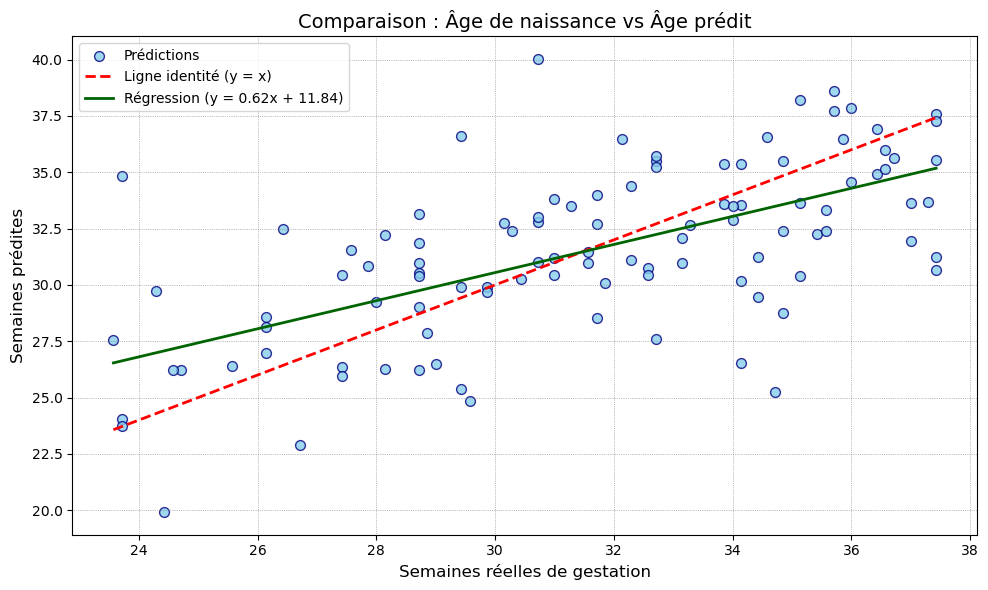

In [173]:
# Calcul de la droite de régression
coef, intercept = np.polyfit(y, y_pred, deg=1)

# Points pour tracer la droite
x_line = np.array([y.min(), y.max()])
y_line = coef * x_line + intercept

# Visualisation améliorée
plt.figure(figsize=(10, 6))

# Nuage de points : bleu clair avec bordure foncée
plt.scatter(
    y, y_pred,
    color='skyblue',
    edgecolor='navy',
    alpha=0.8,
    s=50,
    label="Prédictions"
)

# Ligne d'identité y = x
min_val, max_val = y.min(), y.max()
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color='red',
    linestyle='--',
    linewidth=2,
    label="Ligne identité (y = x)"
)

# Droite de régression
plt.plot(
    x_line, y_line,
    color='darkgreen',
    linestyle='-',
    linewidth=2,
    label=f"Régression (y = {coef:.2f}x + {intercept:.2f})"
)

# Légende
plt.legend(loc='upper left')

# Labels et titre
plt.xlabel("Semaines réelles de gestation", fontsize=12)
plt.ylabel("Semaines prédites", fontsize=12)
plt.title("Comparaison : Âge de naissance vs Âge prédit", fontsize=14)

# Grille discrète
plt.grid(color='gray', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

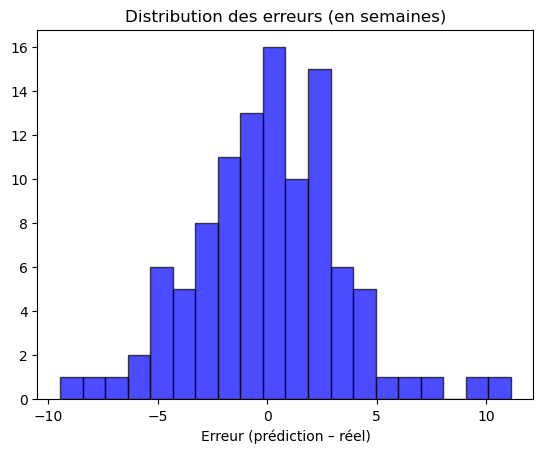

In [155]:
residus = y_pred - y
plt.hist(residus, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution des erreurs (en semaines)")
plt.xlabel("Erreur (prédiction – réel)")
plt.show()

In [159]:
def get_region_list(base_path):
    return sorted([
        d for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
           and not d.startswith('all_models')
           and not d.startswith('hcp')
           and not d.startswith('ukb')
           and not d.endswith('.csv')
           and not d.endswith('.sh')
           and not d.endswith('embeddings')
    ])

In [179]:
def train_regressor(region,birth_threshold=37.5):

    results= {}
    

    # load embeddings
    region_path = os.path.join(base_path, region)

    # Fins the unique subdirectory automatically
    subdirs = [d for d in os.listdir(region_path) if os.path.isdir(os.path.join(region_path, d))]
    if len(subdirs) != 1:
        raise RuntimeError(f"Il y a {len(subdirs)} sous-dossiers dans {region_path}, impossible de choisir automatiquement car il y a plusieurs modèles enregistrés par région.")
    model_folder = subdirs[0]

    # Full path
    embedding_path = os.path.join(region_path, model_folder, "dHCP_random_embeddings", "full_embeddings.csv")

    labels_df = pd.read_csv(labels_path)
    embeddings = pd.read_csv(embedding_path, index_col=0)
    embeddings = embeddings.loc[embeddings.index.isin(labels_df['Subject'])]
    labels = labels_df.set_index('Subject').loc[embeddings.index, 'birth_age']

    #Optionnal : Only keep subjects with age <= 37.5 weeks
    labels = labels[labels <= birth_threshold]
    embeddings = embeddings.loc[labels.index]
    print("Shape embeddings after filtering:", embeddings.shape)
    print("Shape labels after filtering:    ", labels.shape)


    # Standardisation
    scaler = StandardScaler()
    X = scaler.fit_transform(embeddings.values)
    y = labels.values

    # cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=8)

    #Hyperparameter search
    model = LinearRegression()
    param_grid = {'fit_intercept': [True, False]}
    grid_search = GridSearchCV(
        model, param_grid, cv=kf,
        scoring='neg_mean_squared_error', n_jobs=-1
    )
    grid_search.fit(X, y)

    print("Best parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_

    # Prédictions & métriques de régression
    y_pred = cross_val_predict(best_model, X, y, cv=kf)

    mae = mean_absolute_error(y, y_pred)
    r2  = r2_score(y, y_pred)

    # Performance par split
    #cv_mse = -cross_val_score(best_model, X, y, cv=kf, scoring='neg_mean_squared_error')
    cv_r2  =  cross_val_score(best_model, X, y, cv=kf, scoring='r2')
    cv_mae = cross_val_score(best_model, X, y, cv=kf, scoring='neg_mean_absolute_error')

    # Average and std of mae and r2

    mean_cv_mae = -cv_mae.mean()
    std_cv_mae = cv_mae.std()
    mean_cv_r2 = cv_r2.mean()
    std_cv_r2 = cv_r2.std()

    # Return the best parameters, and the metrics

    results['best_params'] = grid_search.best_params_
    results['mean_cv_mae'] = mean_cv_mae
    results['std_cv_mae'] = std_cv_mae
    results['mean_cv_r2'] = mean_cv_r2
    results['std_cv_r2'] = std_cv_r2

    return results



    

        



In [180]:
# Train the regressor for all regions

def get_all_results(base_path, birth_threshold=37.5):
    all_results = {}
    region_list = get_region_list(base_path)
    region_list.remove("analysis")
    region_list.remove("region_list")
    for region in region_list:
        print("Training regressor for region:", region)
        all_results[region] = train_regressor(region, birth_threshold)
    return all_results

In [181]:
# Save the results in a csv file
def save_results_to_csv(all_results, output_path):
    results_df = pd.DataFrame(all_results).T
    results_df.to_csv(output_path)
    print(f"Results saved to {output_path}")




In [182]:
regions= get_region_list(base_path)
print("Regions:", regions)

Regions: ['CINGULATE_left', 'CINGULATE_right', 'FCLp-subsc-FCLa-INSULA_left', 'FCLp-subsc-FCLa-INSULA_right', 'FCMpost-SpC_left', 'FCMpost-SpC_right', 'FColl-SRh_left', 'FColl-SRh_right', 'FIP_left', 'FIP_right', 'FPO-SCu-ScCal_left', 'FPO-SCu-ScCal_right', 'LARGE_CINGULATE_left', 'LARGE_CINGULATE_right', 'Lobule_parietal_sup_left', 'Lobule_parietal_sup_right', 'OCCIPITAL_left', 'OCCIPITAL_right', 'SC-SPeC_left', 'SC-SPeC_right', 'SC-SPoC_left', 'SC-SPoC_right', 'SC-sylv_left', 'SC-sylv_right', 'SFinf-BROCA-SPeCinf_left', 'SFinf-BROCA-SPeCinf_right', 'SFint-FCMant_left', 'SFint-FCMant_right', 'SFint-SR_left', 'SFint-SR_right', 'SFinter-SFsup_left', 'SFinter-SFsup_right', 'SFmarginal-SFinfant_left', 'SFmarginal-SFinfant_right', 'SFmedian-SFpoltr-SFsup_left', 'SFmedian-SFpoltr-SFsup_right', 'SOr-SOlf_left', 'SOr-SOlf_right', 'SOr_left', 'SOr_right', 'SPeC_left', 'SPeC_right', 'SPoC_left', 'SPoC_right', 'STi-SOTlat_left', 'STi-SOTlat_right', 'STi-STs-STpol_left', 'STi-STs-STpol_right', 'S

In [183]:
# Main function
all_results = get_all_results(base_path)
output_path = os.path.join("/neurospin/dico/rmenasria/Runs/01_essai/Output/csv/", "regression_all_regions.csv")
save_results_to_csv(all_results, output_path)


Training regressor for region: CINGULATE_left
Shape embeddings after filtering: (374, 32)
Shape labels after filtering:     (374,)


Best parameters: {'fit_intercept': True}
Training regressor for region: CINGULATE_right
Shape embeddings after filtering: (374, 32)
Shape labels after filtering:     (374,)
Best parameters: {'fit_intercept': True}
Training regressor for region: FCLp-subsc-FCLa-INSULA_left
Shape embeddings after filtering: (374, 32)
Shape labels after filtering:     (374,)
Best parameters: {'fit_intercept': True}
Training regressor for region: FCLp-subsc-FCLa-INSULA_right
Shape embeddings after filtering: (374, 32)
Shape labels after filtering:     (374,)
Best parameters: {'fit_intercept': True}
Training regressor for region: FCMpost-SpC_left
Shape embeddings after filtering: (374, 32)
Shape labels after filtering:     (374,)
Best parameters: {'fit_intercept': True}
Training regressor for region: FCMpost-SpC_right
Shape embeddings after filtering: (374, 32)
Shape labels after filtering:     (374,)
Best parameters: {'fit_intercept': True}
Training regressor for region: FColl-SRh_left
Shape embeddings aft

In [238]:
def plot_regression_performance(csv_path, annotate_top_n=5):
    # Read data
    df = pd.read_csv(csv_path)

    # Clean up the DataFrame
    print(df.columns.tolist())
    df.columns = df.columns.str.strip()
    # Rename first column if necessary
    if "Unnamed: 0" in df.columns:
        df = df.rename(columns={"Unnamed: 0": "region"})

    # Keep relevant columns
    df = df[["region", "mean_cv_mae", "mean_cv_r2", "std_cv_r2", "std_cv_mae"]]
    df = df.rename(columns={"": "region"})  # rename the first column to "region"

    # Create figures
    plt.figure(figsize=(14, 8))
    scatter = sns.scatterplot(
        data=df,
        x="mean_cv_mae",
        y="mean_cv_r2",
        size="std_cv_mae",
        hue="mean_cv_mae",
        palette="plasma_r",
        legend="brief",
        sizes=(20, 200)
    )

    plt.title("Qualité de la régression par région")
    plt.xlabel("Erreur moyenne MAE (plus bas = mieux)")
    plt.ylabel("Score R² moyen (plus haut = mieux)")
    plt.axhline(0, color='grey', linestyle='--', linewidth=1)
    
    # Annotate top and bottom regions
    top_regions = df.sort_values(by="mean_cv_mae", ascending=False).head(annotate_top_n)
    bottom_regions = df.sort_values(by="mean_cv_mae", ascending=True).head(annotate_top_n)

    for _, row in pd.concat([top_regions, bottom_regions]).iterrows():
        plt.text(row["mean_cv_mae"], row["mean_cv_r2"], row["region"],
                 fontsize=8, ha='right', va='bottom')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


['Unnamed: 0', 'best_params', 'mean_cv_mae', 'std_cv_mae', 'mean_cv_r2', 'std_cv_r2']


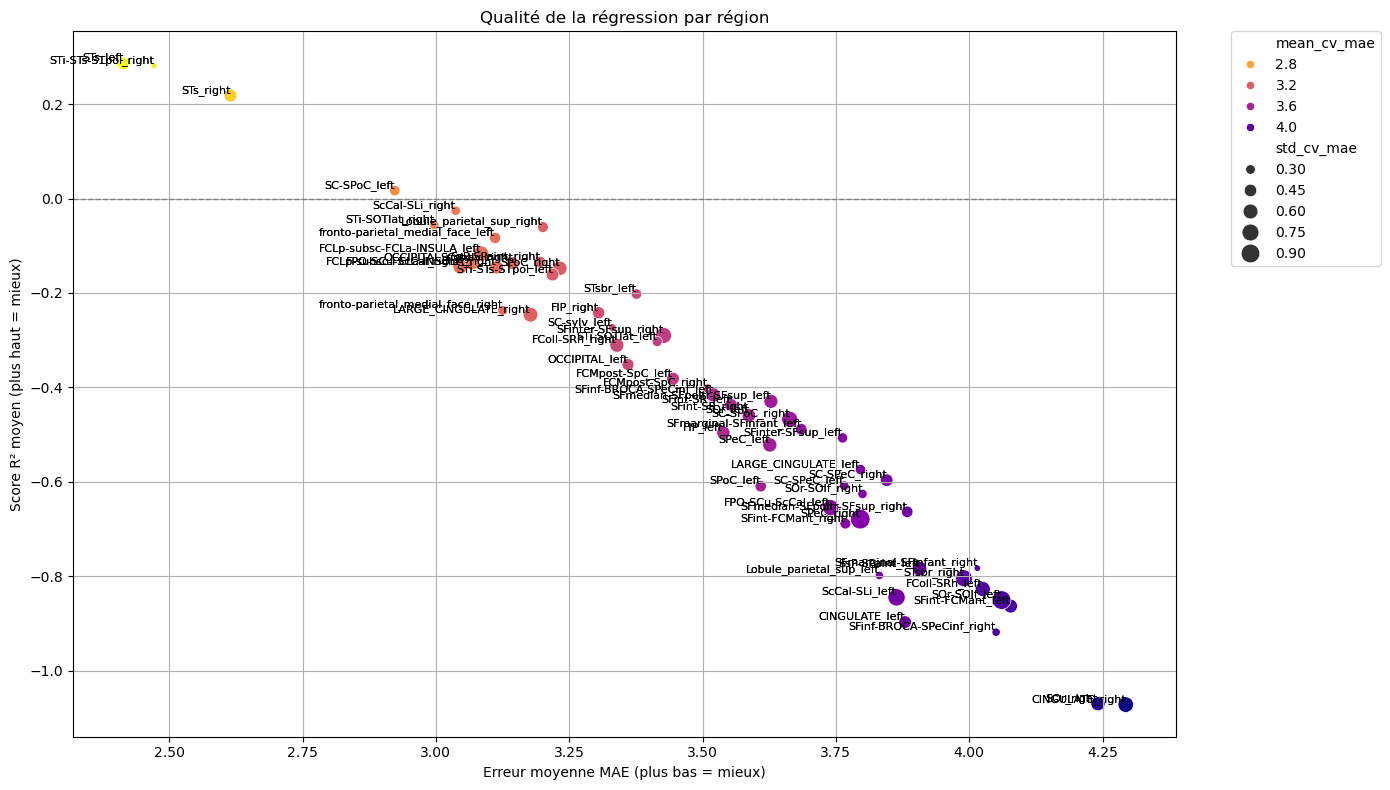

In [240]:
plot_regression_performance("/neurospin/dico/rmenasria/Runs/01_essai/Output/csv/regression_23_37_5_all_regions.csv", annotate_top_n=58)